# Text Classification On News Dataset

* The dataset is called “Twenty Newsgroups”. 

* The 20 Newsgroups data set is a collection of approximately 20,000 newsgroup documents, partitioned (nearly) evenly across 20 different newsgroups.The 20 newsgroups collection has become a popular data set for experiments in text applications of machine learning techniques, such as text classification and text clustering.

* In this notebook we will Explore how Conv1D can be used to learn a pattern from Text features.

* We will build neural network classification Model using Tensorflow.



# <font color='#800028'> <b>1. Load Dataset  </b> </font>

In [4]:
import numpy as np
from tqdm import tqdm
import pandas as pd
import os
import seaborn as sns
from matplotlib import rcParams
import regex as re
from nltk.tree import *
import nltk
from sklearn.metrics import f1_score
nltk.download('maxent_ne_chunker')
nltk.download('averaged_perceptron_tagger')
nltk.download('punkt')
nltk.download('words')
# figure size in inches
rcParams['figure.figsize'] = 11.7,8.27
GLOVE_FILE = 'glove.6B.300d.txt'

[nltk_data] Downloading package maxent_ne_chunker to

[nltk_data]     /root/nltk_data...

[nltk_data]   Unzipping chunkers/maxent_ne_chunker.zip.

[nltk_data] Downloading package averaged_perceptron_tagger to

[nltk_data]     /root/nltk_data...

[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.

[nltk_data] Downloading package punkt to /root/nltk_data...

[nltk_data]   Unzipping tokenizers/punkt.zip.

[nltk_data] Downloading package words to /root/nltk_data...

[nltk_data]   Unzipping corpora/words.zip.


In [ ]:
cd documents

/content/drive/My Drive/Ass/Document Classfication CNN/documents


In [ ]:
filenames = []
labels = []
documentIds = []
for root, dirs, files in os.walk(".", topdown=False):
  for name in files:
    label = name.split("_")[0]
    documentId = name.split("_")[1].split(".")[0]
    labels.append(label)
    documentIds.append(int(documentId))
    _abs_path = os.path.abspath(name)
    filenames.append(name) 


In [ ]:
file_contents = []
count = 0
for file in tqdm(filenames):
  count+=1
  with open(file,'r') as f:
    file_contents.append(f.read())
    


In [ ]:
document_df = pd.DataFrame(list(zip(filenames, labels, documentIds)),
               columns =['filename', 'label', 'documentId'])
document_df['text'] = file_contents
# set documentId as index 
document_df.index = documentIds
document_df.set_index('documentId')
document_df.head()


,filename,label,documentId,text
178989,talk.politics.misc_178989.txt,talk.politics.misc,178989,b'From: rja@mahogany126.cray.com (Russ Anderso...
178431,talk.politics.misc_178431.txt,talk.politics.misc,178431,b'From: steveh@thor.isc-br.com (Steve Hendrick...
178329,talk.politics.misc_178329.txt,talk.politics.misc,178329,b'From: steveh@thor.isc-br.com (Steve Hendrick...
178901,talk.politics.misc_178901.txt,talk.politics.misc,178901,b'From: as010b@uhura.cc.rochester.edu (Tree of...
178643,talk.politics.misc_178643.txt,talk.politics.misc,178643,b'From: k044477@hobbes.kzoo.edu (Jamie R. McCa...


# <font color='#800028'> <b>2. Label Distribution  </b> </font>

In [32]:
raw_doc_df = pd.read_csv('raw_documents.csv')
# raw_doc_df.index = raw_doc_df['documentId']
# raw_doc_df.set_index('documentId')
raw_doc_df.head()

,filename,label,documentId,text
0,talk.politics.misc_178989.txt,talk.politics.misc,178989,b'From: rja@mahogany126.cray.com (Russ Anderso...
1,talk.politics.misc_178431.txt,talk.politics.misc,178431,b'From: steveh@thor.isc-br.com (Steve Hendrick...
2,talk.politics.misc_178329.txt,talk.politics.misc,178329,b'From: steveh@thor.isc-br.com (Steve Hendrick...
3,talk.politics.misc_178901.txt,talk.politics.misc,178901,b'From: as010b@uhura.cc.rochester.edu (Tree of...
4,talk.politics.misc_178643.txt,talk.politics.misc,178643,b'From: k044477@hobbes.kzoo.edu (Jamie R. McCa...


In [34]:

print("Total Number of Unique Document Type  {}".format(np.count_nonzero(np.unique(raw_doc_df['label']))))

Total Number of Unique Document Type  20


Text(0.5, 1.0, 'document_label vs document_label_count')

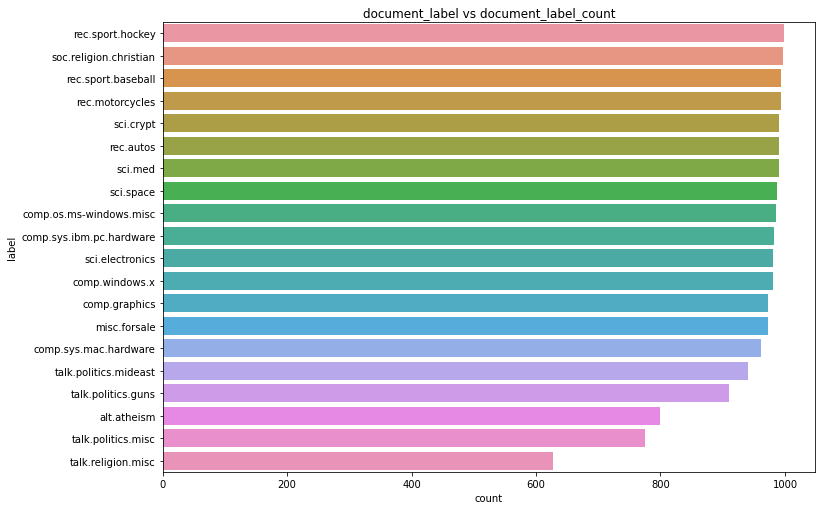

In [35]:
counter_series = raw_doc_df['label'].value_counts()
counter_df = counter_series.to_frame()
counter_df['count'] = counter_df['label']
counter_df['label'] = counter_df.index
ax=sns.barplot(x='count', y='label', data=counter_df)
ax.set_title("document_label vs document_label_count")




# <font color='#800028'> <b>3. Preprocessing  </b> </font>


####  <font color='#800028'> <b>3.1 sample document  </b> </font>
<pre>
<font color='blue'>
Subject: A word of advice
From: jcopelan@nyx.cs.du.edu (The One and Only)

In article < 65882@mimsy.umd.edu > mangoe@cs.umd.edu (Charley Wingate) writes:
>
>I've said 100 times that there is no "alternative" that should think you
>might have caught on by now.  And there is no "alternative", but the point
>is, "rationality" isn't an alternative either.  The problems of metaphysical
>and religious knowledge are unsolvable-- or I should say, humans cannot
>solve them.

How does that saying go: Those who say it can't be done shouldn't interrupt
those who are doing it.

Jim
--
Have you washed your brain today?
</font>
</pre>

####  <font color='#800028'> <b>3.2 Email Preprocessing  </b> </font>
<pre>
useful links: <a href='http://www.pyregex.com/'>http://www.pyregex.com/</a>

<font color='blue'><b>1.</b></font> We will Find all emails in the document and then get the text after the "@". and then split those texts by '.' 
after that remove the words whose length is less than or equal to 2 and also remove'com' word and then combine those words by space. 
In one doc, if we have 2 or more mails, get all.
<b>Eg:[test@dm1.d.com, test2@dm2.dm3.com]-->[dm1.d.com, dm3.dm4.com]-->[dm1,d,com,dm2,dm3,com]-->[dm1,dm2,dm3]-->"dm1 dm2 dm3" </b> 
append all those into one list/array. ( This will give length of 18828 sentences i.e one list for each of the document). 
Some sample output was shown below. 

> In the above sample document there are emails [jcopelan@nyx.cs.du.edu, 65882@mimsy.umd.edu, mangoe@cs.umd.edu]

preprocessing:
[jcopelan@nyx.cs.du.edu, 65882@mimsy.umd.edu, mangoe@cs.umd.edu] ==> [nyx cs du edu mimsy umd edu cs umd edu] ==> 
[nyx edu mimsy umd edu umd edu]

<font color='blue'><b>2.</b></font> Replace all the emails by space in the original text. 
</pre>

In [66]:
# https://stackoverflow.com/questions/41798539/find-email-using-regular-expression-python

# this helper functions will return all the emails from documents
def getEmails(inputText):
  # get all matching group with email regex  
  matchGroups = re.finditer(r'[\w\.-]+@[\w\.-]+(\.[\w]+)+',inputText)
  # get actual email address 
  matchingEmails = [group[0] for group in matchGroups]
  return matchingEmails


def processEmailDomain(doc_emails):
  processed_emails = []
  # iterate over each and every email in perticular text document
  for email in doc_emails :
    # extract domain name from email
    email_parts = email.split("@")
    if email_parts:
      domain = email_parts[1]
    else:
      # if email does not have @ in it domain will be same as email 
      domain = email
    # split the remaining email part(domain ) by '.' 
    email_words = domain.split(".")
    # create a list of all words whose length is greater than 2, remove "com" word as well
    processed_email_words = [word  for word in email_words if len(word) > 2 and word.lower() != 'com']
    # use extend to collect all email domain related word for each document as each element in list
    processed_emails.extend(processed_email_words)
  
  return  " ".join(processed_emails) if len(processed_emails) != 0 else None



def removeEmailFromText(inputText):
  # get all matching group with email regex  
  replaced_text = re.sub(r'[\w\.-]+@[\w\.-]+(\.[\w]+)+'," ", inputText)
  return replaced_text









####  <font color='#800028'> <b>3.3 Preprocess Subjects  </b> </font>
<pre>

<font color='blue'><b>3.</b></font> We will Get subject of the text i.e. get the total lines where "Subject:" occur and remove 
the word which are before the ":" remove the newlines, tabs, punctuations, any special chars.
Eg: if we have sentance like "Subject: Re: Gospel Dating @ \r\r\n" --> You have to get "Gospel Dating" 
Save all this data into another list/array. 

<font color='blue'><b>4.</b></font> After we store it in the list, Replace those sentances in original text by space.
</pre>

In [37]:
def preprocess_subjects(Input_Text):
  # get all matching groups that matches with "Subject:"

  matching = re.search("Subject:.*.\n", Input_Text)
  subject = None
  preprocessed_text = Input_Text
  if matching:
    matching_subject = matching[0]
    # find all matching that follows ":" and replace with empty space
    subject = re.sub(r'^.*:', '', matching_subject)
    # # remove the newlines, tabs, punctuations, any special chars to white space
    subject = re.sub('[^A-Za-z0-9]+', ' ', subject)
    # remove line that match with. "Subject: ... \n"  with empty space
    preprocessed_text = re.sub(r"Subject:.*.\n", "",Input_Text)
    
  return subject, preprocessed_text





####  <font color='#800028'> <b>3.4 Preprocess Tags, brackets  </b> </font>
<pre>


<font color='blue'><b>5.</b></font> We will Delete all the sentances where sentence starts with <b>"Write to:"</b> or <b>"From:"</b>.
> In the above sample document check the 2nd line, we should remove that

<font color='blue'><b>6.</b></font> We will Delete all the tags like "< anyword >"
> In the above sample document check the 4nd line, we should remove that "< 65882@mimsy.umd.edu >"


<font color='blue'><b>7.</b></font> Delete all the data which are present in the brackets. 
In many text data, we observed that, they maintained the explanation of sentence 
or translation of sentence to another language in brackets so remove all those.
<b>Eg: "course that gets you HIRED(Der Kurs, der Sie anstellt)" --> "The course that gets you HIRED"</b>

> In the above sample document check the 4nd line, we should remove that "(Charley Wingate)"

</pre>


In [38]:
def removeUnwantedSymbolsAndText(Input_Text):
  # replace sentences starts with "Write to:" or "From:" with ""
  matching = re.sub("Write to:.*.\n", "", Input_Text)
  matching = re.sub("From:.*.\n","", matching)
  # remove all the string that looks like tags ( < any words > )
  matching = re.sub(r"<*.*>" ,"",matching)
  # remove all brackets ( any word ) from string 
  removed_tags = re.sub(r"[\(\[\<].*?[\)\]\>]" ,"",matching)
  
  
  return removed_tags
  




####  <font color='#800028'> <b>3.5 Preprocess punctuations, newlines, other special cases  </b> </font>
<pre>
<font color='blue'><b>8.</b></font> Remove all the newlines('\n'), tabs('\t'), "-", "\".

<font color='blue'><b>9.</b></font> Remove all the words which ends with <b>":"</b>.
<b>Eg: "Anyword:"</b>
> In the above sample document check the 4nd line, we should remove that "writes:"


<font color='blue'><b>10.</b></font> Decontractions, replace words like below to full words. 
please check the donors choose preprocessing for this 
<b>Eg: can't -> can not, 's -> is, i've -> i have, i'm -> i am, you're -> you are, i'll --> i will </b>

<b> There is no order to do point 6 to 10. but you have to get final output correctly</b>

</pre>

In [39]:
def preprocess_specialletters(Input_Text):
  # remove all the words that ends with : e.g writes: 
  sent = decontracted(Input_Text)
  matching_group = re.sub(r'\w+:\s?','',sent)
  # remove all \n \t \s special characters
  matching_group = re.sub(r'[^A-Za-z0-9]+', ' ', matching_group)
  sent = matching_group.replace('\\r', ' ')
  sent = sent.replace('\\n', ' ')
  sent = sent.replace('\\"', ' ')
  
  return sent
  

In [40]:
# https://stackoverflow.com/questions/19790188/expanding-english-language-contractions-in-python
def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)
    phrase = re.sub(r"don\'t", "do not", phrase)
    phrase = re.sub(r"doesn\'t", "does not", phrase)
    phrase = re.sub(r"didn\'t", "did not", phrase)
    phrase = re.sub(r"couldn\'t", "could not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase



####  <font color='#800028'> <b>3.6 Preprocess chunks </b> </font>
<pre>
<font color='blue'><b>11.</b></font> Do chunking on the text you have after above preprocessing. 
Text chunking, also referred to as shallow parsing, is a task that 
follows Part-Of-Speech Tagging and that adds more structure to the sentence.
So it combines the some phrases, named entities into single word.
So after that combine all those phrases/named entities by separating "_". 
And remove the phrases/named entities if that is a "Person". 
You can use nltk.ne_chunk to get these. 
Below we have given one example. please go through it. 

useful links: 
https://www.nltk.org/book/ch07.html
https://stackoverflow.com/a/31837224/4084039
http://www.nltk.org/howto/tree.html
https://stackoverflow.com/a/44294377/4084039

####  <font color='#800028'> <b>3.7 Other Preprocessing </b> </font>
<pre>
<font color='blue'><b>12.</b></font> Replace all the digits with space i.e delete all the digits. 
> In the above sample document, the 6th line have digit 100, so we have to remove that.

<font color='blue'><b>13.</b></font> After doing above points, we observed there might be few word's like
 <b> "_word_" (i.e starting and ending with the _), "_word" (i.e starting with the _),
  "word_" (i.e ending with the _)</b> remove the <b>_</b> from these type of words. 

<font color='blue'><b>14.</b></font>  We also observed some words like <b> "OneLetter_word"- eg: d_berlin, 
"TwoLetters_word" - eg: dr_berlin </b>, in these words we remove the "OneLetter_" (d_berlin ==> berlin) and 
"TwoLetters_" (de_berlin ==> berlin). i.e remove the words 
which are length less than or equal to 2 after spliiting those words by "_". 

<font color='blue'><b>15.</b></font> Convert all the words into lower case and lowe case 
and remove the words which are greater than or equal to 15 or less than or equal to 2.

<font color='blue'><b>16.</b></font> replace all the words except "A-Za-z_" with space. 

<font color='blue'><b>17.</b></font> Now You got Preprocessed Text, email, subject. create a dataframe with those. 
Below are the columns of the df. 
</pre>


In [41]:
def other_text_processing(Input_Text):
  # removed digit from text and keep all alphabatics and underscore value
  removed_digit_Text = re.sub(r'[^a-zA-Z_]+'," ", Input_Text)
  # removed beggining underscore 
  #["_Helloworld _123 _"]  =>   ["Helloworld 123"] )
  processed_underscore  = re.sub(r"\b_"," ", removed_digit_Text)
  #  removed any tail underscore in between words  
  #["Helloworld_____ Hi"] => ["HelloWorld Hi"] 
  processed_underscore = re.sub(r"_\s"," ", processed_underscore)
  # removed underscore from word
  # ["HelloWorld_ chirag_"] => ["Helloworld chirag"]
  processed_underscore = re.sub(r"_$"," ",processed_underscore)
  # removed all words which has length <=2  before  "_"
  # \b\w{1,2}_\w{1,2}$ 
  # ["Hi_world 1b_USA BN_IN"] => [world USA IN]
  processed_underscore = re.sub(r"\b\w{1,2}_"," ",processed_underscore)

  # remove all the word having length less than 2 or greater than 15 and convert them to lower case
  final_preprocessedtext = " ".join([ word.lower() for word in processed_underscore.split() if len(word) > 2 and len(word) < 15])



  return final_preprocessedtext
  

In [42]:
def preprocess(Input_Text, label, document_id):
    """Do all the Preprocessing as shown above and
    return a tuple contain preprocess_email,preprocess_subject,preprocess_text for that Text_data"""
    # original text
    original_text = Input_Text
    # decode binary string to utf-8 before searching for regex
    Input_Text = Input_Text.replace("\\/", "/").encode().decode('unicode_escape')
    # print(Input_Text)
    # 1. Email processing
    # get all emails in text
    all_emails = getEmails(Input_Text)
    # preprocess all emails
    preprocess_email = processEmailDomain(all_emails)
    # replace email with space
    preprocess_text = removeEmailFromText(Input_Text)
    # 2. subject processing
    subject,preprocess_text  = preprocess_subjects(preprocess_text)
    # remove unwanted symbols
    preprocess_text = removeUnwantedSymbolsAndText(preprocess_text)
    # remove special characters and punctuations
    preprocess_text = preprocess_specialletters(preprocess_text)
    # chunking
    preprocess_text = preprocessChunks(preprocess_text)
    # other processing
    preprocess_text = other_text_processing(preprocess_text)
    
    return (document_id, preprocess_email,subject,preprocess_text, Input_Text, label)

In [43]:
# https://stackoverflow.com/questions/31836058/nltk-named-entity-recognition-to-a-python-list/44294377#44294377
def preprocessChunks(Input_Text):
  # tokenized text
  tokenized_Text = nltk.word_tokenize(Input_Text)
  # get Parts of speech tags
  pos_tags = nltk.pos_tag(tokenized_Text)
  # preprocessed chunks
  chunklist = nltk.ne_chunk(pos_tags) 

  final_processed_chunks = []
  current_chunk_list = []

  for chunk_ele in chunklist:
    if isinstance(chunk_ele, Tree) and chunk_ele.label() != 'PERSON':
      # create a list from all the list [NEW YORK => NEW_YORK, "NEW ENGLAND"=>"NEW_ENGLAND"]
      current_chunk_list.append("_".join([token for token, pos in chunk_ele.leaves()]))
    # if there label is person in pos we will ignore we don't want to consider person
    elif isinstance(chunk_ele, Tree) and chunk_ele.label() == 'PERSON':
      continue
    else:
      final_processed_chunks.append(chunk_ele[0])
    
    if current_chunk_list:
      entity_name = " ".join(current_chunk_list)
      # avoid duplicates
      if entity_name not in final_processed_chunks:
        final_processed_chunks.append(entity_name)
        current_chunk_list =[]


    
  return " ".join(list(final_processed_chunks))  
  
  
  

####  <font color='#800028'> <b>3.8 Creating Final Dataframe </b> </font>


In [51]:
final_processed_features = []
for document_id, text, label in tqdm(zip(raw_doc_df['documentId'], raw_doc_df['text'], raw_doc_df['label'])):
  final_processed_features.append(preprocess(text, label, document_id))
  
  

In [79]:
# convert final features to dataframe save as csv
features_df = pd.DataFrame(final_processed_features, columns=['document_id','preprocess_email','subject','preprocess_text', 'Input_Text','label'])
features_df.to_csv("final_text_processed_features.csv", index=False)


# <font color='#800028'> <b>4. Modeling  </b> </font>

### Training The models to Classify: 

<pre>
1. Combine "preprocessed_text", "preprocessed_subject", "preprocessed_emails" into one column. use that column to model. 

2. Now Split the data into Train and test. use 25% for test also do a stratify split. 

3. Analyze your text data and pad the sequnce if required. 
Sequnce length is not restricted, you can use anything of your choice. 
you need to give the reasoning

4. Do Tokenizer i.e convert text into numbers. please be careful while doing it. 
if you are using tf.keras "Tokenizer" API, it removes the <b>"_"</b>, but we need that.

5. code the model's ( Model-1, Model-2 ) as discussed below 
and try to optimize that models.  

6. For every model use predefined Glove vectors. 
<b>Don't train any word vectors while Training the model.</b>

7. Use "categorical_crossentropy" as Loss. 

8. Use <b>Accuracy and Micro Avgeraged F1 score</b> as your as Key metrics to evaluate your model. 

9.  Use Tensorboard to plot the loss and Metrics based on the epoches.

10. Please save your best model weights in to <b>'best_model_L.h5' ( L = 1 or 2 )</b>. 

11. You are free to choose any Activation function, learning rate, optimizer.
But have to use the same architecture which we are giving below.

12. You can add some layer to our architecture but you <b>deletion</b> of layer is not acceptable.

13. Try to use <b>Early Stopping</b> technique or any of the callback techniques that you did in the previous assignments.

14. For Every model save your model to image ( Plot the model) with shapes 
and inlcude those images in the notebook markdown cell, 
upload those imgages to Classroom. You can use "plot_model" 
please refer <a href='https://www.tensorflow.org/api_docs/python/tf/keras/utils/plot_model'>this</a> if you don't know how to plot the model with shapes. 

</pre>

In [ ]:
features_df["combined_features"] = features_df['preprocess_email'].fillna("") + features_df['subject'].fillna("") + features_df['preprocess_text'].fillna("")
features_df.drop(columns=['subject','preprocess_email','preprocess_text','Input_Text'], inplace=True)
features_df.to_csv("final_combined_features.csv", index=False)

In [5]:
final_features_df = pd.read_csv('final_combined_features.csv')
final_features_df.head()

,document_id,label,combined_features
0,178989,talk.politics.misc,mahogany126 cray apollo apollo srgenprp Cults ...
1,178431,talk.politics.misc,thor isc-br tijc02 uucp tijc02 uucp thor isc-b...
2,178329,talk.politics.misc,thor isc-br sgi417 msd lmsc lockheed lmsc lock...
3,178901,talk.politics.misc,uhura rochester edu optilink optilink hilbert ...
4,178643,talk.politics.misc,hobbes kzoo edu optilink kzoo edu Are American...


# <font color='#800028'> <b>4.1 Stratification and Train Test split  </b> </font>

In [6]:
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.layers import Embedding
from tensorflow.keras import  Input
from tensorflow.keras.utils import  to_categorical
from tensorflow.keras.layers import  Conv1D, Concatenate, Dense, Flatten, MaxPool1D, Dropout
from tensorflow.keras import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import os
import datetime


In [7]:

X = final_features_df

from sklearn.preprocessing import LabelEncoder
# get all unique labels
unique_labels = np.unique(X['label'])
# encode labels to integer
le = LabelEncoder()
encoding = le.fit_transform(unique_labels)
# create dictionary with label string as key and int encoding as value
label_encoding_dict =  dict(zip(unique_labels, encoding))

Y = X['label'].replace(label_encoding_dict)
final_features_df['label_encoding'] = Y
final_features_df.to_csv("final_features_with_encoded_label.csv", index=False)
# convert Y label to categorical one hot encoder


In [8]:
# startified Split
from sklearn.model_selection import train_test_split, StratifiedKFold,StratifiedShuffleSplit
# startified Shuffle 
stratified_shuffle_features = StratifiedShuffleSplit(n_splits=1, test_size=0.25, random_state=123)
train_index, test_index = next(stratified_shuffle_features.split(X, Y))

X_train = X.loc[train_index]
Y_train  =  Y.loc[train_index]
X_test = X.loc[test_index]
y_test =  Y.loc[test_index]


# convert to one hot encoded labels 
Y_train = to_categorical(np.asarray(Y_train))
y_test = to_categorical(np.asarray(y_test))



## <font color='#800028'> <b>Distribution of Train Data </b> </font>

Text(0.5, 1.0, 'X_train document_label vs document_label_count')

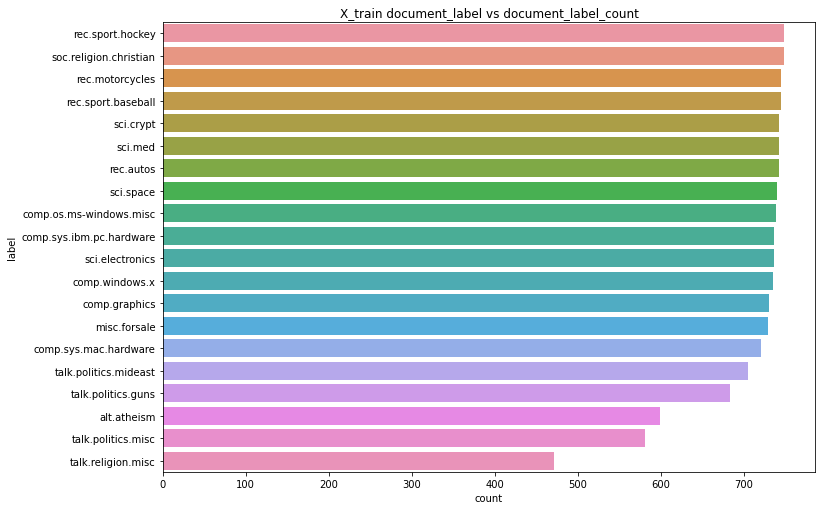

In [9]:

counter_series = X_train['label'].value_counts()
counter_df = counter_series.to_frame()
counter_df['count'] = counter_df['label']
counter_df['label'] = counter_df.index
ax=sns.barplot(x='count', y='label', data=counter_df)
ax.set_title("X_train document_label vs document_label_count")




## <font color='#800028'> <b>Distribution of Test Data </b> </font>

Text(0.5, 1.0, 'X_train document_label vs document_label_count')

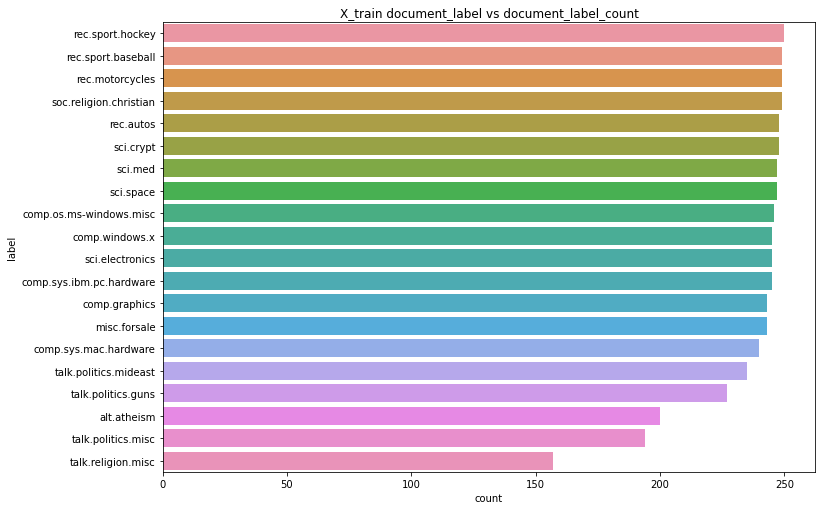

In [10]:

counter_series = X_test['label'].value_counts()
counter_df = counter_series.to_frame()
counter_df['count'] = counter_df['label']
counter_df['label'] = counter_df.index
ax=sns.barplot(x='count', y='label', data=counter_df)
ax.set_title("X_train document_label vs document_label_count")



In [11]:
counter_series

rec.sport.hockey            250
rec.sport.baseball          249
rec.motorcycles             249
soc.religion.christian      249
rec.autos                   248
sci.crypt                   248
sci.med                     247
sci.space                   247
comp.os.ms-windows.misc     246
comp.windows.x              245
sci.electronics             245
comp.sys.ibm.pc.hardware    245
comp.graphics               243
misc.forsale                243
comp.sys.mac.hardware       240
talk.politics.mideast       235
talk.politics.guns          227
alt.atheism                 200
talk.politics.misc          194
talk.religion.misc          157
Name: label, dtype: int64

###  <font color='#800028'> <b> 4.3 Build Models </b> </font>


###  <font color='#800028'> <b> 4.3.1 Model-1: Using 1D convolutions with word embeddings </b> </font>

<pre>
<b>Encoding of the Text </b> --> For a given text data create a Matrix with Embedding layer as shown Below. 
In the example we have considered d = 5, but in this assignment we will get d = dimension of Word vectors we are using.
 i.e if we have maximum of 350 words in a sentence and embedding of 300 dim word vector, 
 we result in 350*300 dimensional matrix for each sentance as output after embedding layer
<img src='https://i.imgur.com/kiVQuk1.png'>

<img src='https://i.imgur.com/fv1GvFJ.png'>

<pre>
1. all are Conv1D layers with any number of filter and filter sizes, there is no restriction on this.

2. use concatenate layer is to concatenate all the filters/channels. 

3. You can use any pool size and stride for maxpooling layer.

4. Don't use more than 16 filters in one Conv layer becuase it will increase the no of params. 
( Only recommendation if you have less computing power )

5. You can use any number of layers after the Flatten Layer.
</pre>

# <font color='#800028'> <b>4.3.2 Prepare the Data for Word Embedding </b> </font>

In [12]:
X_train = X_train['combined_features']
X_test = X_test['combined_features']

In [13]:
# length Analysis in training Data
text_length=[]
for text in X_train:
  text_length.append(len(text))

text_length_series = pd.Series(text_length)
text_length_series.describe().head(10)

count    14121.000000
mean      1151.577650
std       2375.430678
min          9.000000
25%        379.000000
50%        659.000000
75%       1169.000000
max      55995.000000
dtype: float64

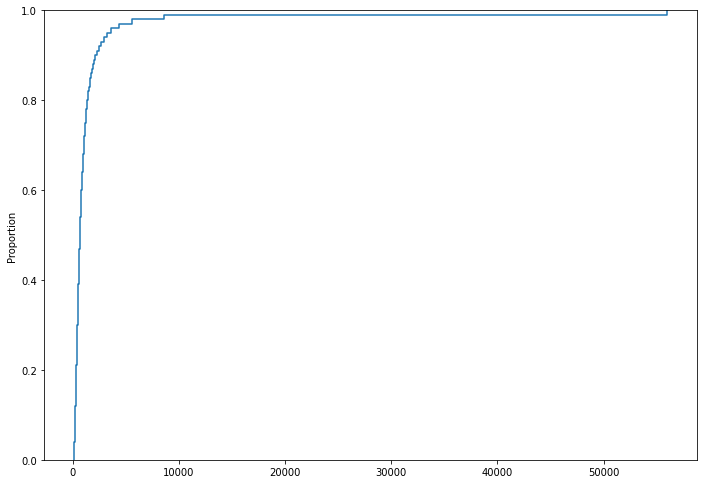

In [14]:
text_length_percentile = []
for id in range(1,101):
  text_length_percentile.append(np.percentile(text_length_series, id))

# plotting cdf of text_length_analysis
sns.ecdfplot(data=text_length_percentile )

In [15]:
print("{}% Documents have length less than {} ".format(95,np.percentile(text_length_series,95)))
print("That's why we are going to choose maximum input length for our model to be 3500")

95% Documents have length less than 3224.0 

That's why we are going to choose maximum input length for our model to be 3500


In [16]:

# Tokenize the Data 
# not using default filters because default filter will filter _ (underscore) which we’re  want
tokenizer = Tokenizer(
  num_words=None,
  filters='!"#$%&()*+,-./:;<=>?@[\\]^`{|}~\t\n',
  lower=True, split=' ', char_level=False, oov_token=None,
  document_count=0, 
)
# prepare tokenizer
tokenizer.fit_on_texts(X_train)
# total number of words in entire training dataset
vocab_size = len(tokenizer.word_index) + 1
# convert to sequences
train_encoded_sequence = tokenizer.texts_to_sequences(X_train)
test_encoded_sequence = tokenizer.texts_to_sequences(X_test)


# # pad documents to a max length of 2500 words
max_length = 3500
train_padded_sequences = pad_sequences(train_encoded_sequence, maxlen=max_length, padding='post')
test_padded_sequences = pad_sequences(test_encoded_sequence, maxlen=max_length, padding='post')




In [18]:

# use Glove Vector for embedding
embedding_index_dict = {}
glove_file = open(GLOVE_FILE)
for line in glove_file:
    values = line.split()
    # file structure
    # word [d dimension values]
    # extract word
    word = values[0]
    # extract all embeddings
    embedding_coeff = np.asarray(values[1:], dtype='float32')
    # update dictionary with embedding values
    embedding_index_dict[word] = embedding_coeff
glove_file.close()


In [19]:
# prepare the embedding matrix using training documents
EMBEDDING_DIMENSION  = 300
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))
embedding_matrix = np.zeros((len(word_index) + 1, EMBEDDING_DIMENSION))
for word, index in word_index.items():
  # get word embedding we created using glove vectors
  word_embedding_from_dict = embedding_index_dict.get(word)
  # if word embedding is none this word is not present in our vectors ignore them
  if word_embedding_from_dict is not None:
    embedding_matrix[index] = word_embedding_from_dict




Found 81539 unique tokens.


In [20]:
# create custom Embedding layer

embedding_layer = Embedding(len(word_index) + 1,
                            EMBEDDING_DIMENSION,
                            weights=[embedding_matrix],
                            input_length=max_length,
                            trainable=False)

In [21]:
len(word_index) +1, EMBEDDING_DIMENSION

(81540, 300)

In [22]:
# custom callback to track validation f1 score
class F1MetricTracker(tf.keras.callbacks.Callback):
    def __init__(self,testX, testY):
        self.x_test = testX
        self.y_test= testY
      
    def on_train_begin(self, logs={}):
        ## on begin of training, we are creating a instance varible called history
        ## it is a dict with keys [validation f1 score]]
        self.history={'val_f1':[]}
        
    def on_epoch_end(self, epoch, logs={}):
        
        y_test_pred_prob = self.model.predict(self.x_test)
        # y_true_labels ( mnulticlass problem so take argmax to get the true label)
        y_true_labels= np.argmax(y_test,axis=1)
        y_pred_labels = np.argmax(y_test_pred_prob, axis=1)


        # f1 score
        val_f1_score = f1_score(y_true_labels, y_pred_labels, average='micro')
        self.history['val_f1'].append(val_f1_score)

        
        print(" validation f1 score : {} ".format( val_f1_score))

In [23]:
# define all callbacks

# tensorboard callbacks
%reload_ext tensorboard

# Custom F1 metric callback
F1_Metric_Callback = F1MetricTracker(test_padded_sequences, y_test)
# early stopping callbacks
early_stopiing_callback = EarlyStopping(monitor='loss', patience=3)
# tensorboard log directory
log_dir = os.path.join("logs_model_1",'fits', datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
# base path to store weights
basePath = 'best_model_1'
# Tensotboard callback to visualize the network parameters         
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir,histogram_freq=1,write_graph=True)
# model checkpoint callbacks
model_checkpoint_callback = ModelCheckpoint(basePath,monitor='val_acc', mode='max', save_best_only=True)

In [25]:
# Model Input each Input sequence will have length = max_length
sequence_Inputs = Input(shape=(max_length,), dtype='int32')
embedded_sequences = embedding_layer(sequence_Inputs)
# x = Conv1D
x1 = Conv1D(128, 3, activation='relu', padding='same')(embedded_sequences)
x2 = Conv1D(128, 5, activation='relu', padding='same' )(embedded_sequences)
x3 = Conv1D(128,7, activation='relu', padding='same')(embedded_sequences)

# concatenate all the outputs from 1DConvolution
x =  Concatenate()([x1, x2, x3])
# maxpool1D
x = MaxPool1D(5)(x)

x4 = Conv1D(64, 3, activation='relu', padding='same')(x)
x5 = Conv1D(64, 5, activation='relu', padding='same' )(x)
x6 = Conv1D(64,7, activation='relu', padding='same')(x)
# concatenate all the outputs from 1DConvolution
x =  Concatenate()([x4, x5, x6])
# maxpool1D
x = MaxPool1D(3)(x)
x =  Conv1D(32, 3, activation='relu', padding='valid')(x)
# max pooling
x = MaxPool1D(35)(x)
# flatten the layer
x = Flatten()(x)
# add dropout
x = Dropout(rate=0.3)(x)
# add dense layer
x = Dense(128, activation='relu')(x)
# output layer with softmax activation
preds = Dense(len(label_encoding_dict), activation='softmax')(x)


model1 = Model(sequence_Inputs, preds)
model1.compile(loss='categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['acc'])

# happy learning!
model1.fit(train_padded_sequences, Y_train, validation_data=(test_padded_sequences, y_test),
          epochs=20, batch_size=128, callbacks=[
                                               early_stopiing_callback,
                                               tensorboard_callback,
                                               model_checkpoint_callback,
                                               F1_Metric_Callback
                                               ])




Epoch 1/20

  6/111 [>.............................] - ETA: 1:41 - loss: 3.0473 - acc: 0.0547WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.2589s vs `on_train_batch_end` time: 0.6305s). Check your callbacks.

111/111 [==============================] - ETA: 0s - loss: 2.6200 - acc: 0.1468WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.

 validation f1 score : 0.32462290206076055 

111/111 [==============================] - 168s 1s/step - loss: 2.6200 - acc: 0.1468 - val_loss: 1.8720 - val_acc: 0.3246

Epoch 2/20

111/111 [==============================] - ETA: 0s - loss: 1.5744 - acc: 0.4406WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.

 validation f1 score : 0.5485447206288506 

111/111 [==============================] - 147s 1s/step - loss: 1.5744 - acc: 0.4406 - val_loss: 1.2678 - val_acc: 0.5485

Epoch 3/20

111/111 [==============================] - ETA:

In [26]:
model1.summary()

Model: "model"

__________________________________________________________________________________________________

 Layer (type)                   Output Shape         Param #     Connected to                     


 input_1 (InputLayer)           [(None, 3500)]       0           []                               

                                                                                                  

 embedding (Embedding)          (None, 3500, 300)    24462000    ['input_1[0][0]']                

                                                                                                  

 conv1d (Conv1D)                (None, 3500, 128)    115328      ['embedding[0][0]']              

                                                                                                  

 conv1d_1 (Conv1D)              (None, 3500, 128)    192128      ['embedding[0][0]']              

                                                                                   

# <font color='#800028'> <b>4.3.2.1 Confusion Matrix  for Word Embedding Model </b> </font>

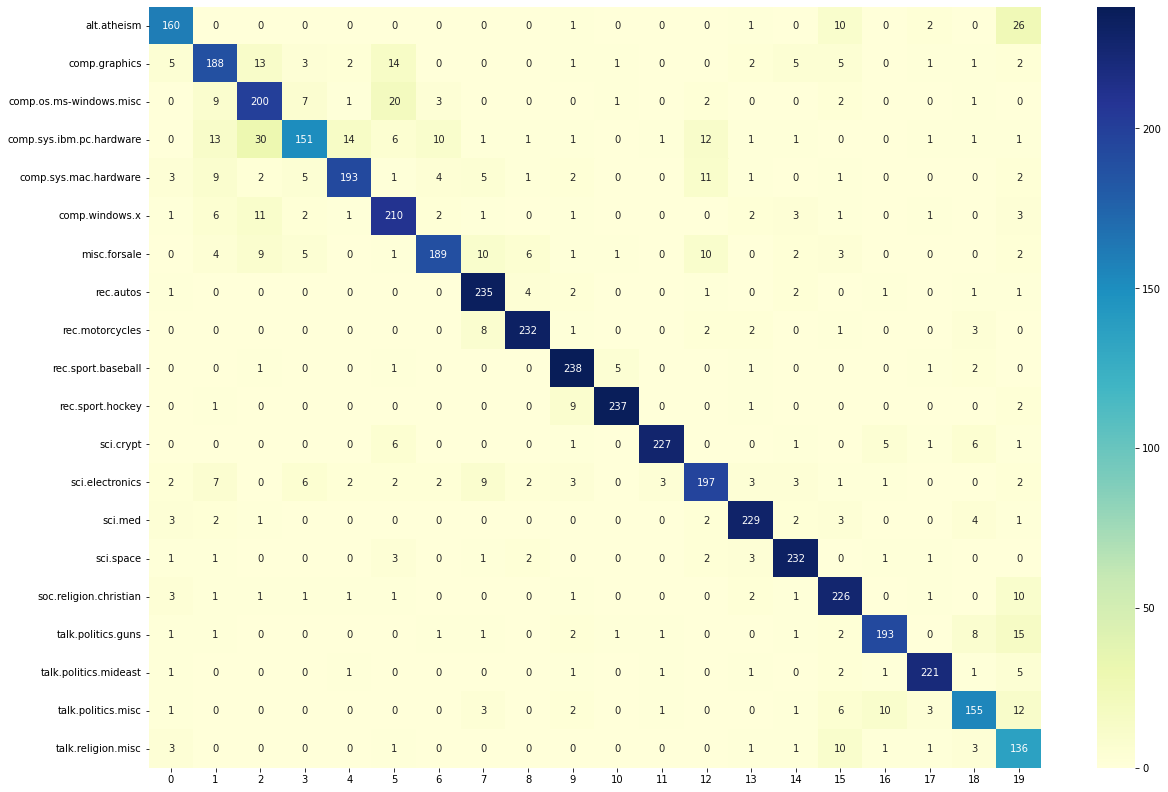

In [29]:
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import multilabel_confusion_matrix, confusion_matrix

y_true_labels = np.argmax(y_test, axis=1)

y_pred = model1.predict(test_padded_sequences)
y_pred_labels = np.argmax(y_pred, axis=1)
y_pred_labels

cf_m =confusion_matrix(y_true_labels, y_pred_labels, labels=[i for i in range(20)])

df_cm = pd.DataFrame(cf_m, index = [i for i in label_encoding_dict.keys()],
                  columns = [i for i in label_encoding_dict.values()])
plt.figure(figsize = (20,14))
sn.heatmap(df_cm, annot=True,cmap="YlGnBu",fmt='.4g')



In [35]:
accuracy_per_class_model1 = np.diag(df_cm)/df_cm.sum(axis=1)
class_accuracy_df = pd.DataFrame(accuracy_per_class_model1, columns=['model 1 class accuracy'])
class_accuracy_df.head(20)

,model 1 class accuracy
alt.atheism,0.800000
comp.graphics,0.773663
comp.os.ms-windows.misc,0.813008
comp.sys.ibm.pc.hardware,0.616327
comp.sys.mac.hardware,0.804167
comp.windows.x,0.857143
misc.forsale,0.777778
rec.autos,0.947581
rec.motorcycles,0.931727
rec.sport.baseball,0.955823




###  <font color='#800028'> <b> 4.3.3 Model-2 : Using 1D convolutions with character embedding </b> </font>



<pre>
<pre><img src="https://i.ytimg.com/vi/CNY8VjJt-iQ/maxresdefault.jpg" width="70%">
Here are the some papers based on Char-CNN
 1. Xiang Zhang, Junbo Zhao, Yann LeCun. <a href="http://arxiv.org/abs/1509.01626">Character-level Convolutional Networks for Text Classification</a>.NIPS 2015
 2. Yoon Kim, Yacine Jernite, David Sontag, Alexander M. Rush. <a href="https://arxiv.org/abs/1508.06615">Character-Aware Neural Language Models</a>. AAAI 2016
 3. Shaojie Bai, J. Zico Kolter, Vladlen Koltun. <a href="https://arxiv.org/pdf/1803.01271.pdf">An Empirical Evaluation of Generic Convolutional and Recurrent Networks for Sequence Modeling</a>
 4. Use the pratrained char embeddings <a href='https://github.com/minimaxir/char-embeddings/blob/master/glove.840B.300d-char.txt'>https://github.com/minimaxir/char-embeddings/blob/master/glove.840B.300d-char.txt</a>
</pre>



<img src='https://i.imgur.com/EuuoJtr.png'>

# <font color='#800028'> <b>4.3.4 Prepare the Data for  Character Embedding </b> </font>

In [9]:
X_train = X_train['combined_features']
X_test = X_test['combined_features']

In [36]:

# Tokenize the Data  for Character level Embedding
print("Tokenizing")
# vocab size
n_char = 70
# character level tokenizer
char_tokenizer = Tokenizer(num_words=n_char, char_level=True, lower=False, filters=None)
# fit tokenizer on text document data
char_tokenizer.fit_on_texts(X_train)
# maximum input length 
max_len = 500 
vocab_size = n_char+1
# create sequence
train_char_encoded_sequence = char_tokenizer.texts_to_sequences(X_train)
test_char_encoded_sequence = char_tokenizer.texts_to_sequences(X_test)

# pad sequence to maximum length
train_char_padded_sequences = pad_sequences(train_char_encoded_sequence, max_len, padding="post", truncating="post", value=0)
test_char_padded_sequences = pad_sequences(test_char_encoded_sequence, max_len, padding="post", truncating="post", value=0)





CHAR_EMB_DIM = 128

Tokenizing


In [46]:

# tensorboard callbacks
%reload_ext tensorboard

# Custom F1 metric callback
F1_Metric_Callback = F1MetricTracker(test_char_padded_sequences, y_test)

# early stopping callbacks
early_stopiing_callback = EarlyStopping(monitor='loss', patience=3)
# tensorboard log directory
log_dir = os.path.join("logs_model_2",'fits', datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
# base path to store weights
basePath = 'best_model_2'
# Tensotboard callback to visualize the network parameters         
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir,histogram_freq=1,write_graph=True)
# model checkpoint callbacks
model_checkpoint_callback = ModelCheckpoint(basePath,monitor='val_acc', mode='max', save_best_only=True)

In [47]:
# create custom Embedding layer

embedding_layer = Embedding(vocab_size,
                            CHAR_EMB_DIM,
                            mask_zero=False,
                            trainable=False)

In [48]:
# Model Input each Input sequence will have length = max_length
sequence_Inputs = Input(shape=(max_len,), dtype='int32')
embedded_sequences = embedding_layer(sequence_Inputs)

x = Conv1D(128, 3, activation='relu', padding='same')(embedded_sequences)
x = Conv1D(128, 5, activation='relu', padding='same' )(x)

# maxpool1D
x = MaxPool1D(15)(x)

x = Conv1D(64, 3, activation='relu', padding='same')(x)
x = Conv1D(64, 5, activation='relu', padding='same' )(x)

# flatten the layer
x = Flatten()(x)
# add dropout
x = Dropout(rate=0.3)(x)
# add dense layer
x = Dense(128, activation='relu')(x)
# output layer with softmax activation
preds = Dense(len(label_encoding_dict), activation='softmax')(x)


model2 = Model(sequence_Inputs, preds)
model2.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['acc'])

# happy learning!
model2.fit(train_char_padded_sequences, Y_train, validation_data=(test_char_padded_sequences, y_test),
          epochs=20, batch_size=128, callbacks=[
                                                early_stopiing_callback,
                                                tensorboard_callback,
                                                F1_Metric_Callback,
                                                model_checkpoint_callback
                                                ]
          )




Epoch 1/20

  6/111 [>.............................] - ETA: 7s - loss: 2.9984 - acc: 0.0391WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0257s vs `on_train_batch_end` time: 0.0418s). Check your callbacks.

110/111 [============================>.] - ETA: 0s - loss: 2.9599 - acc: 0.0765 validation f1 score : 0.10601232207350754 

INFO:tensorflow:Assets written to: best_model_2/assets

111/111 [==============================] - 13s 105ms/step - loss: 2.9596 - acc: 0.0766 - val_loss: 2.9083 - val_acc: 0.1060

Epoch 2/20

110/111 [============================>.] - ETA: 0s - loss: 2.7319 - acc: 0.1345 validation f1 score : 0.17420862545145527 

INFO:tensorflow:Assets written to: best_model_2/assets

111/111 [==============================] - 11s 101ms/step - loss: 2.7309 - acc: 0.1348 - val_loss: 2.4857 - val_acc: 0.1742

Epoch 3/20

110/111 [============================>.] - ETA: 0s - loss: 2.3384 - acc: 0.2320 validation f1 score 

In [49]:
model2.summary()

Model: "model_2"

_________________________________________________________________

 Layer (type)                Output Shape              Param #   


 input_3 (InputLayer)        [(None, 500)]             0         

                                                                 

 embedding_2 (Embedding)     (None, 500, 128)          9088      

                                                                 

 conv1d_11 (Conv1D)          (None, 500, 128)          49280     

                                                                 

 conv1d_12 (Conv1D)          (None, 500, 128)          82048     

                                                                 

 max_pooling1d_4 (MaxPooling  (None, 33, 128)          0         

 1D)                                                             

                                                                 

 conv1d_13 (Conv1D)          (None, 33, 64)            24640     

                                           

# <font color='#800028'> <b>4.3.2.1 Confusion Matrix  for Character  Embedding Model </b> </font>

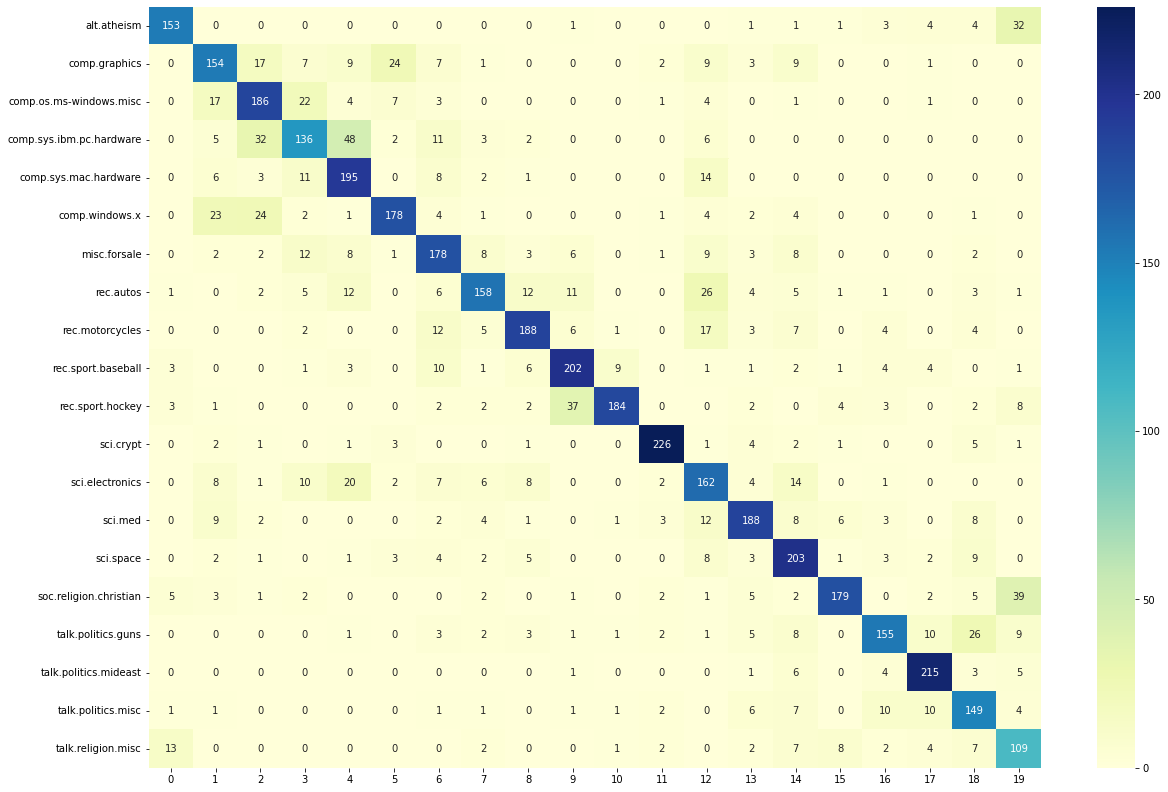

In [51]:

import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import multilabel_confusion_matrix, confusion_matrix

y_true_labels = np.argmax(y_test, axis=1)

y_pred_char = model2.predict(test_char_padded_sequences)
y_pred_char_labels = np.argmax(y_pred_char, axis=1)
y_pred_char_labels

cf_model2 =confusion_matrix(y_true_labels, y_pred_char_labels, labels=[i for i in range(20)])

df_cm_model_2 = pd.DataFrame(cf_model2, index = [i for i in label_encoding_dict.keys()],
                  columns = [i for i in label_encoding_dict.values()])
plt.figure(figsize = (20,14))
sn.heatmap(df_cm_model_2, annot=True,cmap="YlGnBu",fmt='.4g')




In [52]:
accuracy_per_class_model2 = np.diag(df_cm_model_2)/df_cm_model_2.sum(axis=1)
class_accuracy_df_model2 = pd.DataFrame(accuracy_per_class_model2, columns=['model 2 class accuracy'])
class_accuracy_df_model2.head(20)

,model 2 class accuracy
alt.atheism,0.765000
comp.graphics,0.633745
comp.os.ms-windows.misc,0.756098
comp.sys.ibm.pc.hardware,0.555102
comp.sys.mac.hardware,0.812500
comp.windows.x,0.726531
misc.forsale,0.732510
rec.autos,0.637097
rec.motorcycles,0.755020
rec.sport.baseball,0.811245
